In [1]:
import os
import math
import argparse
import itertools
import numpy as np
import pandas as pd
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn import metrics

import utils
from datasets import Data, TransformerDataset
from models import TransformerClassifier

# Argument parser
# parser = argparse.ArgumentParser(description='Transformer Training Script')
# parser.add_argument('--output_dir', type=str, default='even', help='Specify a directory (to be created) for outputs')
# args = parser.parse_args()

# output_dir = args.output_dir
output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)

N = int(1e10)
batch_size = 100
n_epochs = 50

print(f'Using {output_dir} numbered events for training')
print(f'Batch size: {batch_size}')
print('Taking N =', N, ' random events')

# get the device
device = utils.getDevice()
print(f"Using {device} device")

# get the data files
bamboo_results_dir = '../output/DYestimation-v1.2.8-2/results/'
rootFiles = os.listdir(bamboo_results_dir)


def listFiles(prefix):
    return [f'{bamboo_results_dir}{file}' for file in rootFiles if any(p in file for p in prefix)]


data_files = listFiles(['EGamma', 'Muon'])

print('Number of Data root files:', len(data_files))

treenames = [
    'DL_boosted_mumu_skim;1'
]

# The variables for each object
input_features = {
    'l1': ['l1_pt', 'l1_eta', 'l1_phi', 'l1_E'],
    'l2': ['l2_pt', 'l2_eta', 'l2_phi', 'l2_E'],
}

n_features = sum([len(val) for val in input_features.values()])

print('Number of input features:', n_features)

lepton_feat_dim = len(input_features['l1'])

assert lepton_feat_dim == len(input_features['l2'])

data_Data = Data(
    name='Data',
    files=data_files,
    treenames=treenames,
    N=N
)

data_set = [data_Data]

for data in data_set:
    print(f'{data.name} : {data["event_no"].shape[0]} events')

branches = list(itertools.chain.from_iterable(
    list(input_features.values())))

# Need to call them to load into memory
for data in data_set:
    start = time()
    for br in branches:
        data[br]
    print(f'Time passed loading {data.name} files:',
          round(time()-start, 2), 'seconds')


# Make pandas dataframes out of the data
# we're using `sample` to shuffle the data since using all of data is
# computationally expensive and we want to take a really random subset
df = pd.concat([data.get_df.sample(n=min(N, len(data.get_df)))
               for data in data_set])


Using outputs numbered events for training
Batch size: 100
Taking N = 10000000000  random events
Using cuda device
Number of Data root files: 11
Number of input features: 8
Tree DL_boosted_mumu_skim;1 is not in file ../output/DYestimation-v1.2.8-2/results/__skeleton__Muon_Run2022C.root
Tree DL_boosted_mumu_skim;1 is not in file ../output/DYestimation-v1.2.8-2/results/EGamma_Run2022D.root
Tree DL_boosted_mumu_skim;1 is not in file ../output/DYestimation-v1.2.8-2/results/EGamma_Run2022G.root
Data : 29299 events
Time passed loading Data files: 0.4 seconds


In [2]:
df

,file,tree,sample,event_no,l1_pt,l1_eta,l1_phi,l1_E,l2_pt,l2_eta,l2_phi,l2_E
24291,../output/DYestimation-v1.2.8-2/results/Muon_R...,DL_boosted_mumu_skim,Muon_Run2022F.root,370322034,90.884354,-0.710777,-2.924225,114.824928,83.697197,-0.394943,2.319763,90.310097
26917,../output/DYestimation-v1.2.8-2/results/Muon_R...,DL_boosted_mumu_skim,Muon_Run2022G.root,2910550620,112.490028,-0.600540,3.080750,133.391769,67.179260,0.106375,-2.350311,67.559792
7762,../output/DYestimation-v1.2.8-2/results/Muon_R...,DL_boosted_mumu_skim,Muon_Run2022E.root,263225741,150.821411,1.410294,-0.252148,327.375183,75.570969,1.475296,-1.091797,173.852585
13945,../output/DYestimation-v1.2.8-2/results/Muon_R...,DL_boosted_mumu_skim,Muon_Run2022F.root,322051048,174.943359,1.546661,0.354317,429.374390,44.581795,0.849632,-0.454769,61.664711
6790,../output/DYestimation-v1.2.8-2/results/Muon_R...,DL_boosted_mumu_skim,Muon_Run2022E.root,219960744,556.463989,-0.007669,-1.461792,556.480347,55.718548,0.422104,-1.215012,60.756512
...,...,...,...,...,...,...,...,...,...,...,...,...
27598,../output/DYestimation-v1.2.8-2/results/Muon_R...,DL_boosted_mumu_skim,Muon_Run2022G.root,281046704,133.575821,-0.822556,-2.041199,181.370422,81.944260,-1.299179,-2.749268,161.390945
20401,../output/DYestimation-v1.2.8-2/results/Muon_R...,DL_boosted_mumu_skim,Muon_Run2022F.root,1317298873,183.889526,1.482391,-0.721916,425.755554,18.830326,2.245331,0.673111,89.909508
9811,../output/DYestimation-v1.2.8-2/results/Muon_R...,DL_boosted_mumu_skim,Muon_Run2022E.root,770387384,65.204659,1.543671,-1.324448,159.599487,40.280216,1.586624,0.605408,102.550209
20621,../output/DYestimation-v1.2.8-2/results/Muon_R...,DL_boosted_mumu_skim,Muon_Run2022F.root,234513121,73.987717,-0.441959,3.062958,81.332115,27.158724,-1.680756,1.264267,75.444901


In [3]:
# add dummy weight col for now
df['weight'] = 1

In [4]:
# Check for infinite or nan values
inf_indices = df.index[df.isin([np.inf, -np.inf]).any(axis=1)].tolist()
nan_indices = df.index[df.isna().any(axis=1)].tolist()

n_infs = len(inf_indices)
n_nans = len(nan_indices)

if n_infs > 0:
    print(f'Found {n_infs} row(s) that have infinite values in the dataframe.')
    print('Here are them: ', df.iloc[inf_indices])
    print('Removing them.')
    df = df.drop(inf_indices)


if n_nans > 0:
    print(f'Found {n_nans} row(s) that have NaN values in the dataframe.')
    print('Here are the them: ', df.iloc[nan_indices])
    print('Removing them.')
    df = df.drop(nan_indices)

In [5]:
# Split the data into training and validation sets

train_df, valid_df = train_test_split(df, train_size=0.8, shuffle=True)

weight_branch = 'weight'

dataset_train = TransformerDataset(
    df=train_df,
    variable_sets=list(input_features.values()),
    device=device,
)
dataset_test = TransformerDataset(
    df=valid_df,
    variable_sets=list(input_features.values()),
    device=device,
)

# DataLoader
train_dataloader = DataLoader(
    dataset=dataset_train,
    batch_size=batch_size,
    shuffle=True
)
test_dataloader = DataLoader(
    dataset=dataset_test,
    batch_size=batch_size,
    shuffle=False
)

print(
    f'Training set   = {len(dataset_train)} events ({len(train_dataloader)} batches)')
print(
    f'Validation set = {len(dataset_test)} events ({len(test_dataloader)} batches)')

Training set   = 23439 events (235 batches)
Validation set = 5860 events (59 batches)


In [6]:
for batch in train_dataloader:
    print(batch)
    break

tensor([[[ 7.9721e+01, -1.4032e+00,  4.7684e-01,  1.7195e+02],
         [ 2.6702e+01, -1.5532e+00, -1.9949e+00,  6.5930e+01]],

        [[ 1.8137e+02,  1.4992e+00,  2.2700e+00,  4.2634e+02],
         [ 7.7289e+01,  8.4631e-01,  2.6815e+00,  1.0666e+02]],

        [[ 2.2148e+02, -1.6324e+00, -1.6636e+00,  5.8822e+02],
         [ 3.3656e+01, -1.6537e+00, -2.7574e+00,  9.1168e+01]],

        [[ 1.8435e+02,  3.5921e-01,  3.6553e-01,  1.9637e+02],
         [ 2.0341e+01,  1.2437e+00, -9.1197e-01,  3.8210e+01]],

        [[ 1.2554e+02, -1.8457e+00,  3.3275e-01,  4.0742e+02],
         [ 1.9682e+01, -1.5576e+00,  2.7207e+00,  4.8794e+01]],

        [[ 1.1112e+02,  9.0698e-01,  6.3345e-01,  1.6004e+02],
         [ 7.3370e+01,  1.1567e+00, -3.5599e-01,  1.2817e+02]],

        [[ 1.8870e+02, -5.0325e-02,  2.5041e+00,  1.8894e+02],
         [ 9.3602e+01,  1.2932e-01,  1.8503e+00,  9.4386e+01]],

        [[ 1.1931e+02, -2.3326e+00,  1.2098e+00,  6.2048e+02],
         [ 6.9265e+01, -1.3587e+00,  1.26

In [7]:
# Positional Encoding (optional if lepton order matters)
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=2):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)  # (1, max_len, d_model)

    def forward(self, x):
        return x + self.pe.to(x.device)

# Transformer-based Autoencoder
class TransformerAutoencoder(nn.Module):
    def __init__(self, input_dim=4, model_dim=32, nhead=4, num_layers=3):
        super().__init__()
        self.embedding = nn.Linear(input_dim, model_dim)
        self.pos_enc = PositionalEncoding(model_dim)

        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=nhead, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.latent_proj = nn.Linear(model_dim * 2, model_dim)  # combine two leptons

        self.decoder_input = nn.Linear(model_dim, model_dim * 2)
        self.decoder = nn.Sequential(
            nn.Linear(model_dim * 2, 64),
            nn.ReLU(),
            nn.Linear(64, 2 * input_dim)  # outputs 2 leptons × 4 features
        )

    def forward(self, x):
        # x shape: (batch, 2, 4)
        x = self.embedding(x)          # (batch, 2, model_dim)
        x = self.pos_enc(x)
        x = self.encoder(x)            # (batch, 2, model_dim)
        x = x.view(x.size(0), -1)      # (batch, 2*model_dim)
        z = self.latent_proj(x)        # (batch, model_dim)

        dec_input = self.decoder_input(z)
        out = self.decoder(dec_input)
        out = out.view(-1, 2, 4)       # (batch, 2, 4)
        return out

In [8]:
model = TransformerAutoencoder().to(device)

In [9]:
# activation_function = nn.ReLU
# discriminator_model = TransformerClassifier(input_features, num_heads=4, embed_dim=512, hidden_dim=512, num_classes=1, activation_function=activation_function)

In [10]:
# Hyperparameters
embed_dim = 64
num_heads = 16
hidden_dim = 256
learning_rate = 1e-3
activation_function = nn.ReLU

if torch.cuda.device_count() > 1:
  print("Using", torch.cuda.device_count(), "GPUs!")
  model = nn.DataParallel(model)

# loss_fn = utils.WeightedLoss(nn.MSELoss)
loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, mode='min', patience=5, factor=0.5, threshold_mode='abs', eps=1e-6)


early_stopping = utils.EarlyStopping(patience=6, delta=1e-6)


def train(model, dataloader, loss_function, optimizer, training_loss, LR=[]):
    n_batches = len(dataloader)
    lr = optimizer.param_groups[0]['lr']
    LR.append(lr)
    model.train()
    epoch_loss_sum = 0.0
    for batch in dataloader:
        x = batch
        y = model(x)
        batch_loss = loss_function(y, x)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        epoch_loss_sum += batch_loss.item()
    avg_loss = epoch_loss_sum / n_batches
    training_loss.append(avg_loss)


def validate(model, dataloader, loss_function, scheduler, avg_val_loss):
    n_batches = len(dataloader)
    model.eval()
    val_loss_sum = 0.0
    with torch.no_grad():
        for batch in dataloader:
            x = batch
            y = model(x)
            val_loss_sum += (loss_function(y, x)).item()
    avg_epoch_loss = val_loss_sum / n_batches
    avg_val_loss.append(avg_epoch_loss)
    scheduler.step(avg_epoch_loss)

steps_per_epoch = math.ceil(len(dataset_train) / train_dataloader.batch_size)

# metrics
avg_val_loss = []
training_loss = []
learning_rate = []

# training and validation loop
for i in tqdm(range(n_epochs)):
    train(model, train_dataloader, loss_function=loss_fn,
          optimizer=optimizer, training_loss=training_loss, LR=learning_rate)
    validate(model, test_dataloader, loss_function=loss_fn, scheduler=scheduler,
             avg_val_loss=avg_val_loss)
    if early_stopping(avg_val_loss, learning_rate):
        print(f'Early stopping at epoch: {i+1}')
        break

print("Training complete!")



100%|██████████| 50/50 [02:34<00:00,  3.10s/it]

Training complete!


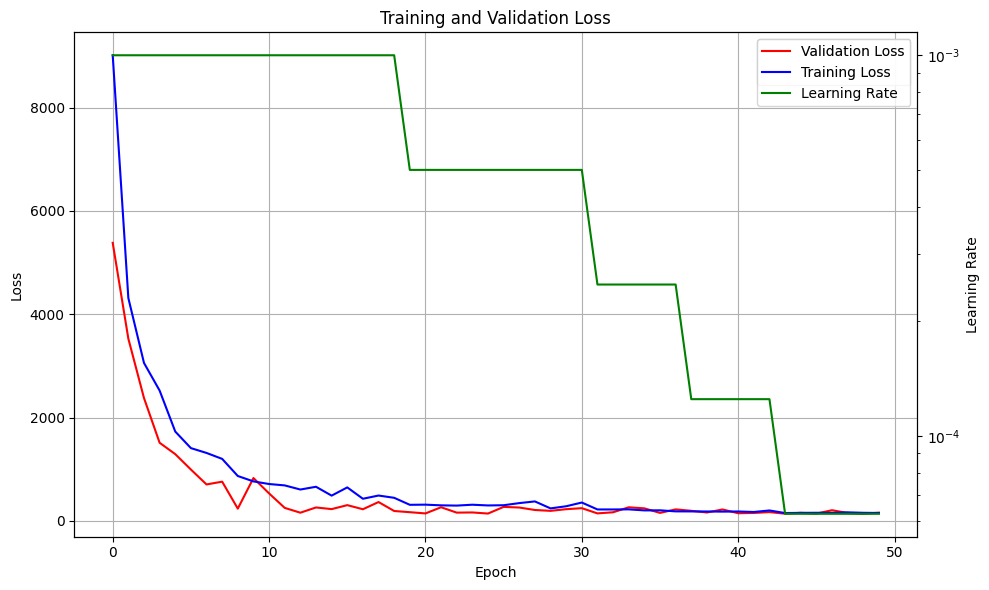

Loss and LR plotted
Saved model to outputs/model.onnx
Simplifying...
Finish! Here is the difference:
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃                    ┃ Original Model ┃ Simplified Model ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ Add                │ 20             │ 17               │
│ Cast               │ 12             │ 0                │
│ Concat             │ 31             │ 4                │
│ Constant           │ 207            │ 61               │
│ Div                │ 6              │ 0                │
│ Gather             │ 25             │ 10               │
│ Gemm               │ 7              ��� 7                │
│ LayerNormalization │ 6              │ 6                │
│ MatMul             │ 16             │ 16               │
│ Mod                │ 3              │ 0                │
│ Mul                │ 12             │ 6                │
│ Relu               │ 4              │ 4                │
│ Reshape   

0

In [11]:
# Create a figure for plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the training and validation loss
ax.plot(avg_val_loss, color='red', label='Validation Loss')
ax.plot(training_loss, color='blue', label='Training Loss')
ax.grid(True)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training and Validation Loss')
ax.legend()

# Add a secondary y-axis for learning rate
ax2 = ax.twinx()
ax2.plot(learning_rate, color='green', label='Learning Rate')
ax2.set_yscale('log')
ax2.set_ylabel('Learning Rate')

# Combine legends from both axes
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.tight_layout()
plt.show()
fig.savefig(f'{output_dir}/loss_and_LR.png')

print('Loss and LR plotted')

dummy_input = torch.randn(1, 2, 4).to(device)

dynamic_axes = {}
for item in input_features.keys():
    dynamic_axes[item] = {0: 'dynamic_size'}
dynamic_axes['output'] = {0: 'dynamic_size'}

onnx_output = torch.onnx.export(
    model,
    dummy_input,
    f"{output_dir}/model.onnx",
    input_names=list(input_features.keys()),
    output_names=['output'],
    dynamic_axes=dynamic_axes)
print(f"Saved model to {output_dir}/model.onnx")


# simplify the onnx file
os.system(
    f'python -m onnxsim {output_dir}/model.onnx {output_dir}/model_simplified.onnx')


In [33]:
# Step 1: Collect all latent vectors from real data
all_latents = []
model.eval()
with torch.no_grad():
    for batch in train_dataloader:
        batch = batch.to(device)
        embedded = model.embedding(batch)
        encoded = model.encoder(model.pos_enc(embedded))
        flat = encoded.view(encoded.size(0), -1)
        latents = model.latent_proj(flat)
        all_latents.append(latents.cpu())
all_latents = torch.cat(all_latents, dim=0)  # shape: (N, latent_dim)

# Step 2: Resample from real latent vectors
num_samples = 1000
indices = np.random.choice(all_latents.shape[0], size=num_samples, replace=True)
z_samples = all_latents[indices].to(device)

# Step 3: Decode
with torch.no_grad():
    dec_input = model.decoder_input(z_samples)
    generated = model.decoder(dec_input)
    generated_data = generated.view(-1, 2, 4)

In [34]:
def compute_mll(leptons):  
    """
    leptons: Tensor of shape (2, 4) with features (pT, eta, phi, E)
    Returns: Tensor of shape (1) with invariant mass
    """
    pT, eta, phi, E = leptons[:, 0], leptons[:, 1], leptons[:, 2], leptons[:, 3]
    
    px = pT * torch.cos(phi)
    py = pT * torch.sin(phi)
    pz = pT * torch.sinh(eta)

    E_tot = E[0] + E[1]
    px_tot = px[0] + px[1]
    py_tot = py[0] + py[1]
    pz_tot = pz[0] + pz[1]

    m2 = E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2)
    mll = torch.sqrt(torch.clamp(m2, min=1e-6))  # avoid negative sqrt
    return mll


In [35]:
mll_data = []
mll_gen = []
for batch in test_dataloader:
    for leptons in batch:
        mll_data.append(compute_mll(leptons).cpu().numpy())

for leptons in generated_data:
    mll_gen.append(compute_mll(leptons).cpu().numpy())


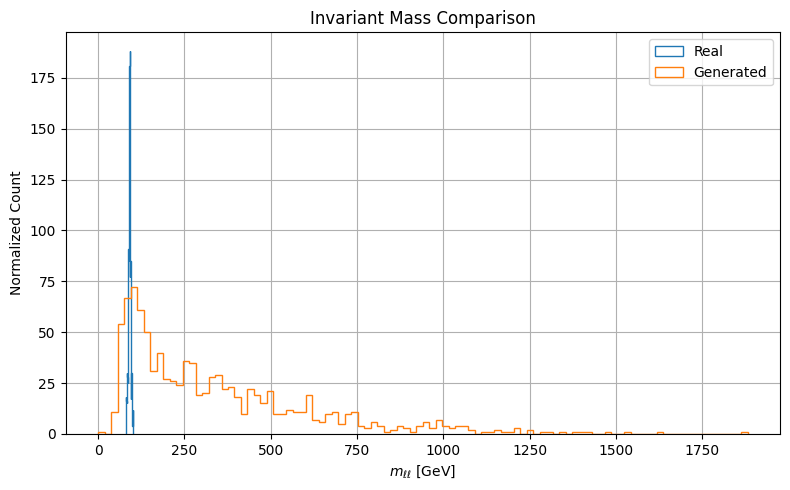

Saved mll comparison plot to outputs/mll_comparison.png


In [36]:
plt.figure(figsize=(8, 5))
plt.hist(mll_data, bins=100, histtype='step', label='Real')
plt.hist(mll_gen,  bins=100, histtype='step', label='Generated')
plt.xlabel(r'$m_{\ell\ell}$ [GeV]')
plt.ylabel('Normalized Count')
plt.legend()
plt.title('Invariant Mass Comparison')
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{output_dir}/mll_comparison.png')
plt.show()
print(f'Saved mll comparison plot to {output_dir}/mll_comparison.png')